In [1]:
# Cell 1: Mount Google Drive and set paths
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = "/content/drive/MyDrive/DATA-DIR"


OUTPUT_DIR = "/content/drive/MyDrive/pneumonia_experiment_results_Real"
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("DATA_DIR =", DATA_DIR)
print("OUTPUT_DIR =", OUTPUT_DIR)



Mounted at /content/drive
DATA_DIR = /content/drive/MyDrive/DATA-DIR
OUTPUT_DIR = /content/drive/MyDrive/pneumonia_experiment_results_Real


In [2]:
# Cell 2: imports, reproducibility helpers
import os, sys, time, copy, math, random
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Matplotlib for plotting
import matplotlib.pyplot as plt

# Reproducibility helper
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)


In [3]:
# Cell 3: Configuration (hyperparams and options)
CONFIG = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "backbones": [
         "wide_resnet50_2", "inception_v3"
    ],
    "run_modes": ["transfer"],
    "freeze_backbone_for_transfer": True,
    "epochs": 20,
    "batch_size": 64,
    "image_size_default": 224,
    "lr_head": 1e-4,
    "lr_scratch": 1e-3,
    "use_amp": True,
    "num_workers": 4,
    "expected_train_counts": {
        "normal": 1341,
        "pneumonia": 3875
    },
    "expected_test_counts": {
        "normal": 234,
        "pneumonia": 390
    },
    "save_dir": OUTPUT_DIR,
    "seed": 42
}

device = torch.device(CONFIG["device"])
print("Using device:", device)
torch.backends.cudnn.benchmark = True


Using device: cuda


In [4]:
# Cell 4: utilities
def check_dataset_structure(base_dir):
    if not os.path.isdir(base_dir):
        raise FileNotFoundError(f"{base_dir} not found. Upload dataset to Drive and set DATA_DIR correctly.")
    entries = sorted(os.listdir(base_dir))
    print(f"Top-level entries in {base_dir} : {entries}")
    # expect train/test folders
    for sub in ("train","test"):
        p = os.path.join(base_dir, sub)
        if not os.path.isdir(p):
            print(f"WARNING: Expected subfolder '{sub}' in {base_dir}. Please ensure {p} exists.")
        else:
            print(f"{sub} subfolder OK, classes: {sorted(os.listdir(p))}")

def compute_pos_weight(train_targets, class_names):
    # find index for pneumonia class heuristically
    pos_idx = None
    for i, nm in enumerate(class_names):
        if 'pneu' in nm.lower():
            pos_idx = i
            break
    if pos_idx is None:
        pos_idx = 1 if len(class_names)>1 else 0
    labels = np.array(train_targets)
    unique, counts = np.unique(labels, return_counts=True)
    count_map = dict(zip(unique, counts))
    n_pos = count_map.get(pos_idx, 0)
    n_neg = len(labels) - n_pos
    pos_weight = (n_neg / n_pos) if n_pos>0 else 1.0
    return pos_weight, pos_idx, count_map

def compute_metrics_from_preds(labels, probs, threshold=0.5):
    pred_labels = (np.array(probs) >= threshold).astype(int)
    labels = np.array(labels).astype(int)
    acc = accuracy_score(labels, pred_labels)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, pred_labels, average='binary', zero_division=0)
    # compute specificity (TN/(TN+FP)) and G-mean = sqrt(sensitivity * specificity)
    tn, fp, fn, tp = confusion_matrix(labels, pred_labels).ravel()
    specificity = tn / (tn + fp) if (tn + fp)>0 else 0.0
    sensitivity = rec
    gmean = math.sqrt(specificity * sensitivity) if specificity>=0 else 0.0
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1, "specificity":specificity, "gmean":gmean, "tp":tp, "tn":tn, "fp":fp, "fn":fn}


In [5]:
# Cell 5: Transforms factory
from torchvision.transforms import InterpolationMode

def get_transforms(img_size, is_train=True):
    if is_train:
        return transforms.Compose([
            transforms.Lambda(lambda img: img.convert("RGB")),  # grayscale->RGB replication
            transforms.RandomResizedCrop(img_size, scale=(0.8,1.0), interpolation=InterpolationMode.BILINEAR),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.0, hue=0.0),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
        ])
    else:
        return transforms.Compose([
            transforms.Lambda(lambda img: img.convert("RGB")),
            transforms.Resize(int(img_size*1.14), interpolation=InterpolationMode.BILINEAR),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
        ])

In [6]:
# Cell 6: Model factory (supports all backbones)
def build_model(backbone_name, pretrained=True, freeze_backbone=True):
    b = backbone_name.lower()
    if b == "resnet18":
        m = models.resnet18(pretrained=pretrained)
        in_feats = m.fc.in_features
        m.fc = nn.Linear(in_feats, 1)
    elif b == "resnet50":
        m = models.resnet50(pretrained=pretrained)
        in_feats = m.fc.in_features
        m.fc = nn.Linear(in_feats, 1)
    elif b == "densenet161":
        m = models.densenet161(pretrained=pretrained)
        in_feats = m.classifier.in_features
        m.classifier = nn.Linear(in_feats, 1)
    elif b == "mobilenet_v2":
        m = models.mobilenet_v2(pretrained=pretrained)
        in_feats = m.classifier[1].in_features
        m.classifier[1] = nn.Linear(in_feats, 1)
    elif b == "shufflenet_v2_x1_0":
        m = models.shufflenet_v2_x1_0(pretrained=pretrained)
        in_feats = m.fc.in_features
        m.fc = nn.Linear(in_feats, 1)
    elif b == "resnext50_32x4d":
        m = models.resnext50_32x4d(pretrained=pretrained)
        in_feats = m.fc.in_features
        m.fc = nn.Linear(in_feats, 1)
    elif b == "wide_resnet50_2":
        m = models.wide_resnet50_2(pretrained=pretrained)
        in_feats = m.fc.in_features
        m.fc = nn.Linear(in_feats, 1)
    elif b == "inception_v3":
      # use pretrained with aux_logits=True
      m = models.inception_v3(pretrained=pretrained, aux_logits=True)
      # main classifier
      in_feats = m.fc.in_features
      m.fc = nn.Linear(in_feats, 1)
      # aux classifier
      if m.aux_logits:
        m.AuxLogits.fc = nn.Linear(m.AuxLogits.fc.in_features, 1)


    else:
        raise ValueError(f"Unknown backbone: {backbone_name}")

    # Freeze backbone except final classifier head if requested (paper's transfer setting)
    if freeze_backbone:
        for name, param in m.named_parameters():
            # Keep fc or classifier trainable
            if ("fc" in name) or ("classifier" in name) or name.startswith("fc") or name.startswith("classifier"):
                param.requires_grad = True
            else:
                param.requires_grad = False
    return m



In [7]:
# Cell 7: create dataloaders for a given image size and transforms
def make_dataloaders(base_dir, img_size, batch_size, num_workers):
    train_dir = os.path.join(base_dir, "train")
    test_dir  = os.path.join(base_dir, "test")
    train_ds = datasets.ImageFolder(root=train_dir, transform=get_transforms(img_size, is_train=True))
    test_ds  = datasets.ImageFolder(root=test_dir, transform=get_transforms(img_size, is_train=False))
    # Basic sanity print
    print("Classes (train):", train_ds.classes)
    print("Num train samples:", len(train_ds), "Num test samples:", len(test_ds))
    return train_ds, test_ds, DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True), DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

# Quick check dataset structure (will not stop execution)
check_dataset_structure(DATA_DIR)



Top-level entries in /content/drive/MyDrive/DATA-DIR : ['test', 'train']
train subfolder OK, classes: ['NORMAL', 'PNEUMONIA']
test subfolder OK, classes: ['NORMAL', 'PNEUMONIA']


In [8]:
# Cell 8: training & evaluation functions (AMP-enabled)
scaler = torch.cuda.amp.GradScaler(enabled=CONFIG["use_amp"] and device.type=="cuda")

def train_epoch(model, loader, criterion, optimizer, device, use_amp):
    model.train()
    losses = []
    all_probs = []
    all_labels = []
    for imgs, labels in tqdm(loader, desc="Train batches", leave=False):
        imgs = imgs.to(device)
        labels = labels.float().to(device).unsqueeze(1)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=use_amp and device.type=="cuda"):
            logits = model(imgs)
            loss = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        losses.append(loss.item())
        probs = torch.sigmoid(logits).detach().cpu().numpy().ravel().tolist()
        all_probs.extend(probs)
        all_labels.extend(labels.detach().cpu().numpy().ravel().tolist())

    metrics = compute_metrics_from_preds(all_labels, all_probs)
    metrics["loss"] = float(np.mean(losses) if len(losses)>0 else 0.0)
    return metrics

def eval_epoch(model, loader, criterion, device, use_amp):
    model.eval()
    losses = []
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Eval batches", leave=False):
            imgs = imgs.to(device)
            labels = labels.float().to(device).unsqueeze(1)
            with torch.cuda.amp.autocast(enabled=use_amp and device.type=="cuda"):
                logits = model(imgs)
                loss = criterion(logits, labels)
            losses.append(loss.item())
            probs = torch.sigmoid(logits).detach().cpu().numpy().ravel().tolist()
            all_probs.extend(probs)
            all_labels.extend(labels.detach().cpu().numpy().ravel().tolist())

    metrics = compute_metrics_from_preds(all_labels, all_probs)
    metrics["loss"] = float(np.mean(losses) if len(losses)>0 else 0.0)
    return metrics

def run_experiment(backbone, mode, base_dir, config):
    """
    backbone: string name
    mode: 'transfer' or 'scratch'
    """
    print(f"\n=== RUN: backbone={backbone} | mode={mode} ===")
    # image size special case for inception
    img_size = 299 if backbone.lower()=="inception_v3" else config["image_size_default"]
    train_ds, test_ds, train_loader, test_loader = make_dataloaders(base_dir, img_size, config["batch_size"], config["num_workers"])

    # compute pos_weight for BCE
    pos_weight, pos_idx, counts = compute_pos_weight(train_ds.targets, train_ds.classes)
    print("pos_weight:", pos_weight, "pos_idx:", pos_idx, "class_names:", train_ds.classes, "counts:", counts)

    # Check against paper reported counts (sanity)
    lower_names = [c.lower() for c in train_ds.classes]
    try:
        n_train_normal = counts[lower_names.index("normal")] if "normal" in lower_names else None
        n_train_pneumonia = counts[lower_names.index("pneumonia")] if "pneumonia" in lower_names else None
    except Exception:
        n_train_normal = None; n_train_pneumonia = None
    # warn if counts differ substantially
    if n_train_normal is not None and n_train_pneumonia is not None:
        e_n = config["expected_train_counts"]
        if abs(n_train_normal - e_n["normal"]) > 50 or abs(n_train_pneumonia - e_n["pneumonia"])>50:
            print("WARNING: Your train counts differ from the paper's reported counts. This is fine if you used different splits, but recorded metrics may differ from paper.")

    # Build model
    pretrained_flag = True if mode=="transfer" else False
    freeze_flag = config["freeze_backbone_for_transfer"] if mode=="transfer" else False
    model = build_model(backbone, pretrained=pretrained_flag, freeze_backbone=freeze_flag)
    model = model.to(device)

    # Choose optimizer & lr
    params = [p for p in model.parameters() if p.requires_grad]
    lr = config["lr_head"] if mode=="transfer" else config["lr_scratch"]
    optimizer = torch.optim.Adam(params, lr=lr)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], dtype=torch.float).to(device))

    best_val_f1 = -1.0
    best_wts = None
    history = []

    for epoch in range(1, config["epochs"]+1):
        t0 = time.time()
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device, config["use_amp"])
        val_metrics = eval_epoch(model, test_loader, criterion, device, config["use_amp"])
        epoch_time = time.time() - t0

        history.append({
            "epoch": epoch,
            "train_loss": train_metrics["loss"],
            "train_acc": train_metrics["acc"],
            "train_prec": train_metrics["prec"],
            "train_rec": train_metrics["rec"],
            "train_f1": train_metrics["f1"],
            "train_spec": train_metrics["specificity"],
            "train_gmean": train_metrics["gmean"],
            "val_loss": val_metrics["loss"],
            "val_acc": val_metrics["acc"],
            "val_prec": val_metrics["prec"],
            "val_rec": val_metrics["rec"],
            "val_f1": val_metrics["f1"],
            "val_spec": val_metrics["specificity"],
            "val_gmean": val_metrics["gmean"],
            "time_sec": epoch_time
        })

        print(f"[{backbone}|{mode}] Epoch {epoch:02d} | Tr F1={train_metrics['f1']:.4f} Val F1={val_metrics['f1']:.4f} | Val Acc={val_metrics['acc']:.4f} | Time {epoch_time:.1f}s")

        if val_metrics["f1"] > best_val_f1:
            best_val_f1 = val_metrics["f1"]
            best_wts = copy.deepcopy(model.state_dict())
            best_model_path = os.path.join(config["save_dir"], f"best_{backbone}_{mode}.pth")
            torch.save(best_wts, best_model_path)

    # Save history CSV
    hist_df = pd.DataFrame(history)
    hist_csv = os.path.join(config["save_dir"], f"history_{backbone}_{mode}.csv")
    hist_df.to_csv(hist_csv, index=False)
    print(f"Saved history CSV -> {hist_csv}")
    print(f"Best val F1 = {best_val_f1:.4f} saved to {best_model_path if best_wts is not None else 'N/A'}")
    return {"backbone":backbone, "mode":mode, "best_f1":best_val_f1, "history_csv":hist_csv, "best_model_path": best_model_path if best_wts is not None else None}


/tmp/ipython-input-4246689068.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=CONFIG["use_amp"] and device.type=="cuda")


In [9]:
# Cell 9: Run experiments.
set_seed(CONFIG["seed"])

RUN_BACKBONES = CONFIG["backbones"]
RUN_MODES = CONFIG["run_modes"]

summary_results = []
for backbone in RUN_BACKBONES:
    for mode in RUN_MODES:
        res = run_experiment(backbone, mode, DATA_DIR, CONFIG)
        summary_results.append(res)
        # optionally free memory
        torch.cuda.empty_cache()

# Save summary
summary_df = pd.DataFrame(summary_results)
summary_csv = os.path.join(CONFIG["save_dir"], "summary_all_experiments.csv")
summary_df.to_csv(summary_csv, index=False)
print("All experiments finished. Summary saved to", summary_csv)
print(summary_df)



=== RUN: backbone=wide_resnet50_2 | mode=transfer ===
Classes (train): ['NORMAL', 'PNEUMONIA']
Num train samples: 5216 Num test samples: 624
pos_weight: 0.3460645161290323 pos_idx: 1 class_names: ['NORMAL', 'PNEUMONIA'] counts: {np.int64(0): np.int64(1341), np.int64(1): np.int64(3875)}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weight

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


100%|██████████| 132M/132M [00:00<00:00, 191MB/s]
Train batches:   0%|          | 0/82 [00:00<?, ?it/s]/tmp/ipython-input-4246689068.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=="cuda"):
Eval batches:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-4246689068.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instea

[wide_resnet50_2|transfer] Epoch 01 | Tr F1=0.8066 Val F1=0.5088 | Val Acc=0.5545 | Time 671.3s


Train batches:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-4246689068.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=="cuda"):
Eval batches:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, wh

[wide_resnet50_2|transfer] Epoch 02 | Tr F1=0.8811 Val F1=0.7694 | Val Acc=0.7292 | Time 118.0s


Train batches:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-4246689068.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=="cuda"):
Eval batches:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, wh

[wide_resnet50_2|transfer] Epoch 03 | Tr F1=0.8958 Val F1=0.7055 | Val Acc=0.6843 | Time 121.1s


Train batches:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-4246689068.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=="cuda"):
Eval batches:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, wh

[wide_resnet50_2|transfer] Epoch 04 | Tr F1=0.9083 Val F1=0.7254 | Val Acc=0.7003 | Time 118.1s


Train batches:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-4246689068.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=="cuda"):
Eval batches:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, wh

[wide_resnet50_2|transfer] Epoch 05 | Tr F1=0.9026 Val F1=0.7493 | Val Acc=0.7212 | Time 118.5s


Train batches:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-4246689068.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=="cuda"):
Eval batches:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, wh

[wide_resnet50_2|transfer] Epoch 06 | Tr F1=0.9024 Val F1=0.7812 | Val Acc=0.7468 | Time 120.6s


Train batches:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-4246689068.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=="cuda"):
Eval batches:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, wh

[wide_resnet50_2|transfer] Epoch 07 | Tr F1=0.9102 Val F1=0.8081 | Val Acc=0.7708 | Time 119.5s


Train batches:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-4246689068.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=="cuda"):
Eval batches:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, wh

[wide_resnet50_2|transfer] Epoch 08 | Tr F1=0.9121 Val F1=0.7770 | Val Acc=0.7452 | Time 120.4s


Train batches:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-4246689068.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=="cuda"):
Eval batches:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, wh

[wide_resnet50_2|transfer] Epoch 09 | Tr F1=0.9155 Val F1=0.7911 | Val Acc=0.7580 | Time 117.9s


Train batches:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-4246689068.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=="cuda"):
Eval batches:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, wh

[wide_resnet50_2|transfer] Epoch 10 | Tr F1=0.9145 Val F1=0.7928 | Val Acc=0.7612 | Time 118.3s


Train batches:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-4246689068.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=="cuda"):
Eval batches:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, wh

[wide_resnet50_2|transfer] Epoch 11 | Tr F1=0.9151 Val F1=0.8269 | Val Acc=0.7901 | Time 118.9s


Train batches:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-4246689068.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=="cuda"):
Eval batches:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, wh

[wide_resnet50_2|transfer] Epoch 12 | Tr F1=0.9192 Val F1=0.8000 | Val Acc=0.7676 | Time 120.4s


Train batches:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-4246689068.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=="cuda"):
Eval batches:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, wh

[wide_resnet50_2|transfer] Epoch 13 | Tr F1=0.9171 Val F1=0.8109 | Val Acc=0.7772 | Time 120.4s


Train batches:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-4246689068.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=="cuda"):
Eval batches:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, wh

[wide_resnet50_2|transfer] Epoch 14 | Tr F1=0.9215 Val F1=0.8161 | Val Acc=0.7804 | Time 119.7s


Train batches:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-4246689068.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=="cuda"):
Eval batches:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, wh

[wide_resnet50_2|transfer] Epoch 15 | Tr F1=0.9241 Val F1=0.8438 | Val Acc=0.8077 | Time 120.4s


Train batches:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-4246689068.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=="cuda"):
Eval batches:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, wh

[wide_resnet50_2|transfer] Epoch 16 | Tr F1=0.9273 Val F1=0.8375 | Val Acc=0.8029 | Time 120.3s


Train batches:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-4246689068.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=="cuda"):
Eval batches:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, wh

[wide_resnet50_2|transfer] Epoch 17 | Tr F1=0.9247 Val F1=0.8379 | Val Acc=0.8029 | Time 120.9s


Train batches:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-4246689068.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=="cuda"):
Eval batches:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, wh

[wide_resnet50_2|transfer] Epoch 18 | Tr F1=0.9237 Val F1=0.8262 | Val Acc=0.7917 | Time 118.9s


Train batches:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-4246689068.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=="cuda"):
Eval batches:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, wh

[wide_resnet50_2|transfer] Epoch 19 | Tr F1=0.9274 Val F1=0.8391 | Val Acc=0.8045 | Time 119.6s


Train batches:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-4246689068.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=="cuda"):
Eval batches:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, wh

[wide_resnet50_2|transfer] Epoch 20 | Tr F1=0.9255 Val F1=0.8324 | Val Acc=0.7981 | Time 118.5s
Saved history CSV -> /content/drive/MyDrive/pneumonia_experiment_results_Real/history_wide_resnet50_2_transfer.csv
Best val F1 = 0.8438 saved to /content/drive/MyDrive/pneumonia_experiment_results_Real/best_wide_resnet50_2_transfer.pth

=== RUN: backbone=inception_v3 | mode=transfer ===
Classes (train): ['NORMAL', 'PNEUMONIA']
Num train samples: 5216 Num test samples: 624
pos_weight: 0.3460645161290323 pos_idx: 1 class_names: ['NORMAL', 'PNEUMONIA'] counts: {np.int64(0): np.int64(1341), np.int64(1): np.int64(3875)}
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 196MB/s] 
Train batches:   0%|          | 0/82 [00:00<?, ?it/s]/tmp/ipython-input-4246689068.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=="cuda"):


AttributeError: 'InceptionOutputs' object has no attribute 'size'

Summary CSV not found: /content/drive/MyDrive/pneumonia_experiment_results_Real/summary_all_experiments.csv


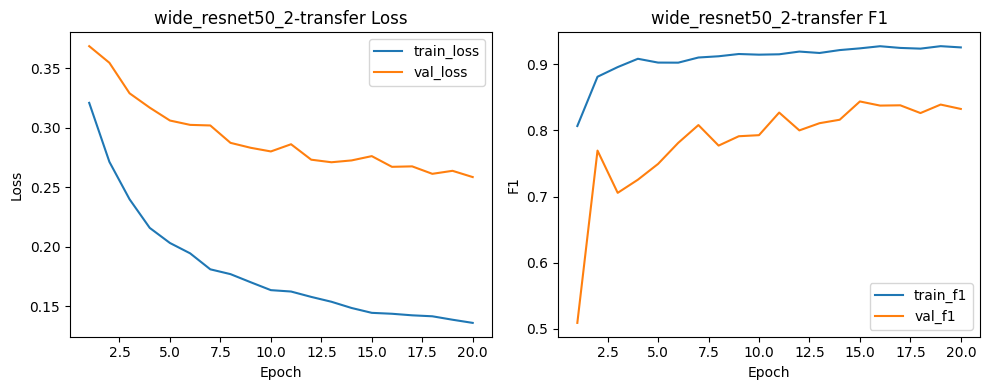

In [10]:
# Cell 10: Load summary and plot per-backbone curves for quick inspection
summary_csv = os.path.join(CONFIG["save_dir"], "summary_all_experiments.csv")
if os.path.exists(summary_csv):
    summary_df = pd.read_csv(summary_csv)
    print(summary_df)
else:
    print("Summary CSV not found:", summary_csv)

def plot_history(backbone, mode):
    hist_csv = os.path.join(CONFIG["save_dir"], f"history_{backbone}_{mode}.csv")
    if not os.path.exists(hist_csv):
        print("History CSV not found:", hist_csv); return
    df = pd.read_csv(hist_csv)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(df["epoch"], df["train_loss"], label="train_loss")
    plt.plot(df["epoch"], df["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title(f"{backbone}-{mode} Loss")
    plt.subplot(1,2,2)
    plt.plot(df["epoch"], df["train_f1"], label="train_f1")
    plt.plot(df["epoch"], df["val_f1"], label="val_f1")
    plt.xlabel("Epoch"); plt.ylabel("F1"); plt.legend(); plt.title(f"{backbone}-{mode} F1")
    plt.tight_layout()
    plt.show()

plot_history("wide_resnet50_2","transfer")